In [1]:
from __future__ import print_function, division
from builtins import range, input

import pickle
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

In [11]:
import tensorflow
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dot, Add, Flatten, Dense, Concatenate
from tensorflow.keras.layers import Dropout, BatchNormalization, Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD, Adam
from numpy.random import seed
seed(1)
#tensorflow.random.set_seed(2)

C:\Users\I073890\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\I073890\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\I073890\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\I073890\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarnin

In [6]:
# load in the data
df = pd.read_csv('C:\\JYO DATA\\SAP\\Innovator Challenge\\editedLong_App_Usage_count.csv')

C:\Users\I073890\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
df.shape

(231676, 27)

In [9]:
N = df.cust_idx.max() + 1 # number of users
M = df.fiori_idx.max() + 1 # number of movies

L = df.role_name.max() + 1 # number of roles
O = df.app_comp.max() + 1 # number of app comp

In [10]:
df_lob = df[df.columns[15:]].copy()
df_lob_cat = len(df_lob.columns)

In [11]:
# split into train and test
df = shuffle(df)
cutoff = int(0.8*len(df))
df_train = df.iloc[:cutoff]
df_test = df.iloc[cutoff:]

In [12]:
df_train_lob = df_train[df_train.columns[15:]].copy()
df_test_lob  = df_test[df_test.columns[15:]].copy()

In [13]:
# initialize variables
K = 10 # latent dimensionality
mu = df_train.USAGE_COUNT_NORM.mean()
epochs = 20
reg = 0.001 # regularization penalty

In [14]:
# keras model
u = Input(shape=(1,))
m = Input(shape=(1,))
rn = Input(shape=(1,))
ac = Input(shape=(1,))
lob = [Input(shape=(1,)) for i in range(df_lob_cat)]

In [15]:
u_embedding = Embedding(N, K)(u) # (N, 1, K)
m_embedding = Embedding(M, K)(m) # (N, 1, K)
r_embedding = Embedding(L, K)(rn) # (N, 1, K)
c_embedding = Embedding(O, K)(ac) # (N, 1, K)
lob_embedding_list = [Embedding(2, K)(lob[i]) for i in range(df_lob_cat)]

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [16]:
u_bias = Embedding(N, 1)(u) # (N, 1, 1)
m_bias = Embedding(M, 1)(m) # (N, 1, 1)
r_bias = Embedding(L, 1)(rn) # (N, 1, 1)
c_bias = Embedding(O, 1)(ac) # (N, 1, 1)

In [17]:
##### main branch
x = Dot(axes=2)([u_embedding, m_embedding]) # (N, 1, 1)
x = Add()([x, u_bias, m_bias])
x = Flatten()(x) # (N, 1)

In [18]:
##### side branch
r_embedding = Flatten()(r_embedding) # (N, K)
c_embedding = Flatten()(c_embedding) # (N, K)
u_embedding = Flatten()(u_embedding) # (N, K)
m_embedding = Flatten()(m_embedding) # (N, K)

In [20]:
lob_embedding_flatlist = [Flatten()(lob_emb) for lob_emb in lob_embedding_list]
emb_l = [u_embedding, m_embedding, r_embedding, c_embedding]
for lob_flat in lob_embedding_flatlist:
    emb_l.append(lob_flat)
y = Concatenate()(emb_l) # (N, 2K)

In [21]:
y = Dense(512, kernel_regularizer = l2(reg) )(y)
# y = BatchNormalization()(y)
y = Activation('elu')(y)
y = Dense(512, kernel_regularizer = l2(reg) )(y)
# y = BatchNormalization()(y)
y = Activation('elu')(y)
y = Dense(512, kernel_regularizer = l2(reg) )(y)
# y = BatchNormalization()(y)
y = Activation('elu')(y)
y = Dense(512, kernel_regularizer = l2(reg) )(y)
# y = BatchNormalization()(y)
y = Activation('elu')(y)
y = Dense(1)(y)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [22]:
##### merge
x = Add()([x, y])
m_in = [u, m, rn, ac]
for i in range(df_lob_cat):
    m_in.append(lob[i])

In [23]:
model = Model(inputs=m_in, outputs=x)
model.compile(
  loss='mse',
  # optimizer='adam',
  # optimizer=Adam(lr=0.01),
  optimizer=SGD(lr=0.08, momentum=0.9),
  # metrics=[tensorflow.keras.metrics.RootMeanSquaredError()],
  metrics=[tensorflow.keras.metrics.RootMeanSquaredError(),tensorflow.keras.metrics.MeanSquaredError(),tensorflow.keras.metrics.CosineSimilarity(),tensorflow.keras.metrics.MeanAbsoluteError()],

)

In [24]:
inp = [df_train.cust_idx.values, df_train.fiori_idx.values, df_train.role_name.values, df_train.app_comp.values]
oup = [df_test.cust_idx.values, df_test.fiori_idx.values, df_test.role_name.values, df_test.app_comp.values]
for col in df_train_lob.columns:
    inp.append(df_train_lob[col].values)
    oup.append(df_test_lob[col].values)

In [25]:
r = model.fit(
  x=inp,
  y=df_train.USAGE_COUNT_NORM.values - mu,
  epochs=epochs,
  batch_size=128,
  validation_data=(
    oup,
    df_test.USAGE_COUNT_NORM.values - mu
  )
)

Train on 185340 samples, validate on 46336 samples
Epoch 1/20
185340/185340 [==============================] - 23s 126us/sample - loss: 1.1690 - root_mean_squared_error: 0.8809 - mean_squared_error: 0.7760 - cosine_similarity: 0.5784 - mean_absolute_error: 0.6254 - val_loss: 0.6582 - val_root_mean_squared_error: 0.7962 - val_mean_squared_error: 0.6339 - val_cosine_similarity: 0.6493 - val_mean_absolute_error: 0.5400
Epoch 2/20
185340/185340 [==============================] - 26s 141us/sample - loss: 0.6058 - root_mean_squared_error: 0.7721 - mean_squared_error: 0.5961 - cosine_similarity: 0.6584 - mean_absolute_error: 0.5230 - val_loss: 0.5887 - val_root_mean_squared_error: 0.7637 - val_mean_squared_error: 0.5833 - val_cosine_similarity: 0.6695 - val_mean_absolute_error: 0.5232
Epoch 3/20
185340/185340 [==============================] - 26s 143us/sample - loss: 0.5167 - root_mean_squared_error: 0.7159 - mean_squared_error: 0.5126 - cosine_similarity: 0.6948 - mean_absolute_error: 0.475

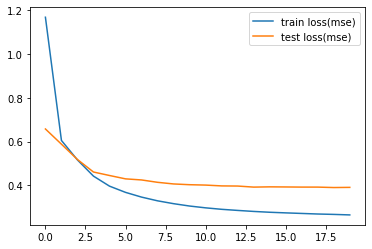

In [26]:
# plot losses
plt.plot(r.history['loss'], label="train loss(mse)")
plt.plot(r.history['val_loss'], label="test loss(mse)")
plt.legend()
plt.show()

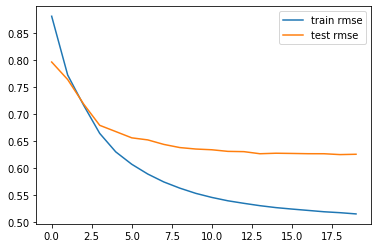

In [27]:
# plot mse
plt.plot(r.history['root_mean_squared_error'], label="train rmse")
plt.plot(r.history['val_root_mean_squared_error'], label="test rmse")
plt.legend()
plt.show()

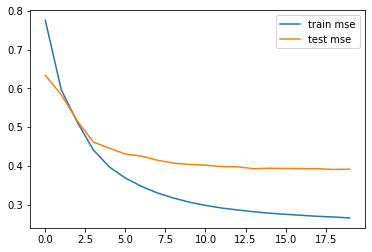

In [28]:
# plot mse
plt.plot(r.history['mean_squared_error'], label="train mse")
plt.plot(r.history['val_mean_squared_error'], label="test mse")
plt.legend()
plt.show()

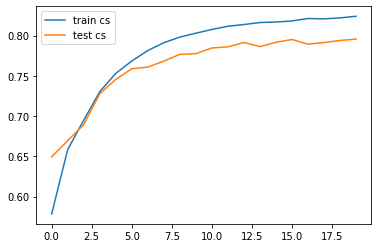

In [29]:
# plot mse
plt.plot(r.history['cosine_similarity'], label="train cs")
plt.plot(r.history['val_cosine_similarity'], label="test cs")
plt.legend()
plt.show()

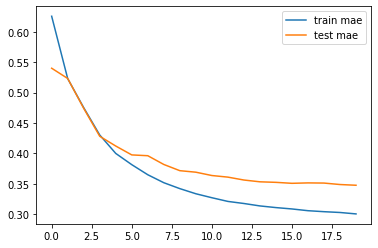

In [30]:
# plot mse
plt.plot(r.history['mean_absolute_error'], label="train mae")
plt.plot(r.history['val_mean_absolute_error'], label="test mae")
plt.legend()
plt.show()

In [31]:
model.save('model_final_version')

# Prediction

In [3]:
df = pd.read_csv('C:\\JYO DATA\\SAP\\Innovator Challenge\\editedLong_App_Usage_count.csv')

C:\Users\I073890\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
df.head()

,Unnamed: 0,Unnamed: 0.1,CALWEEK,CUSTNO,FIORIID,LOB,ROLE_NAME,APP_COMP,USAGE_COUNT,cust_idx,...,Finance,Human Resources,Manufacturing,Marketing,R&D/Engineering,Sales,Service,Sourcing and Procurement,Supply Chain,Sustainability
0,0,0,202024,323561,F0402A,"Finance, Sourcing and Procurement, Supply Chain",Purchasing Manager,MM,50,1773,...,1,0,0,0,0,0,0,1,1,0
1,1,1,202027,323561,F0402A,"Finance, Sourcing and Procurement, Supply Chain",Purchasing Manager,MM,50,1773,...,1,0,0,0,0,0,0,1,1,0
2,2,4,202024,323561,F5000,Finance,General Ledger Accountant - Intercompany,CA,50,1773,...,1,0,0,0,0,0,0,0,0,0
3,3,7,202027,323561,F5000,Finance,General Ledger Accountant - Intercompany,CA,50,1773,...,1,0,0,0,0,0,0,0,0,0
4,4,8,202027,323561,F2446,"Finance, Sourcing and Procurement, Supply Chain",Employee - Procurement,MM,50,1773,...,1,0,0,0,0,0,0,1,1,0


In [5]:
user_det_col = ['CUSTNO', 'cust_idx', 'ROLE_NAME', 'role_name']
user_df = df[user_det_col].drop_duplicates(subset=None, keep='first', inplace=False)

In [6]:
user_df.head()

,CUSTNO,cust_idx,ROLE_NAME,role_name
0,323561,1773,Purchasing Manager,24
2,323561,1773,General Ledger Accountant - Intercompany,117
4,323561,1773,Employee - Procurement,113
5,323561,1773,Maintenance Planner,157
8,323561,1773,General Ledger Accountant,112


In [7]:
fiori_det_col = ['FIORIID', 'fiori_idx', 'APP_COMP', 'app_comp', 'LOB']
fiori_det_col.extend(df.columns[15:])
app_df = df[fiori_det_col].drop_duplicates(subset=None, keep='first', inplace=False)

In [8]:
app_df.head()

,FIORIID,fiori_idx,APP_COMP,app_comp,LOB,Asset Management,Commerce,Finance,Human Resources,Manufacturing,Marketing,R&D/Engineering,Sales,Service,Sourcing and Procurement,Supply Chain,Sustainability
0,F0402A,1248,MM,25,"Finance, Sourcing and Procurement, Supply Chain",0,0,1,0,0,0,0,0,0,1,1,0
2,F5000,899,CA,29,Finance,0,0,1,0,0,0,0,0,0,0,0,0
4,F2446,870,MM,25,"Finance, Sourcing and Procurement, Supply Chain",0,0,1,0,0,0,0,0,0,1,1,0
5,F2953,248,PM,1,"Asset Management, Finance, Manufacturing, Service",1,0,1,0,1,0,0,0,1,0,0,0
8,F2728,240,FI,9,Finance,0,0,1,0,0,0,0,0,0,0,0,0


In [9]:
user_df = user_df.head(2)
#user_df.head()
cross_df_arr = user_df.merge(app_df, how='cross')

In [13]:
model =tensorflow.keras.models.load_model("C:\\Users\\I073890\\model final version")

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [14]:
pred_cols = ['cust_idx', 'fiori_idx', 'role_name', 'app_comp']
pred_cols.extend(df.columns[15:])

In [15]:
pred_inp = []
# cross_df_arr = cross_df_arr.head(10968)
for col in pred_cols:
    pred_inp.append(np.array(cross_df_arr[col]))

In [18]:
predictions = model.predict(pred_inp)
predictions_df = pd.DataFrame(predictions,columns=['predicted_usage_count'])
concat_pred_df = pd.concat([cross_df_arr, predictions_df], axis=1)

In [19]:
concat_pred_df.head()

,CUSTNO,cust_idx,ROLE_NAME,role_name,FIORIID,fiori_idx,APP_COMP,app_comp,LOB,Asset Management,...,Human Resources,Manufacturing,Marketing,R&D/Engineering,Sales,Service,Sourcing and Procurement,Supply Chain,Sustainability,predicted_usage_count
0,323561,1773,Purchasing Manager,24,F0402A,1248,MM,25,"Finance, Sourcing and Procurement, Supply Chain",0,...,0,0,0,0,0,0,1,1,0,-1.240456
1,323561,1773,Purchasing Manager,24,F5000,899,CA,29,Finance,0,...,0,0,0,0,0,0,0,0,0,-1.210516
2,323561,1773,Purchasing Manager,24,F2446,870,MM,25,"Finance, Sourcing and Procurement, Supply Chain",0,...,0,0,0,0,0,0,1,1,0,-1.422380
3,323561,1773,Purchasing Manager,24,F2953,248,PM,1,"Asset Management, Finance, Manufacturing, Service",1,...,0,1,0,0,0,1,0,0,0,-1.286757
4,323561,1773,Purchasing Manager,24,F2728,240,FI,9,Finance,0,...,0,0,0,0,0,0,0,0,0,-1.218167


In [22]:
concat_pred_df.sort_values(by=['predicted_usage_count'], ascending=False).head(10)

,CUSTNO,cust_idx,ROLE_NAME,role_name,FIORIID,fiori_idx,APP_COMP,app_comp,LOB,Asset Management,...,Human Resources,Manufacturing,Marketing,R&D/Engineering,Sales,Service,Sourcing and Procurement,Supply Chain,Sustainability,predicted_usage_count
1334,323561,1773,Purchasing Manager,24,F1797,1156,IS,17,NaN,0,...,0,0,0,0,0,0,0,0,0,2.925956
2705,323561,1773,General Ledger Accountant - Intercompany,117,F1797,1156,IS,17,NaN,0,...,0,0,0,0,0,0,0,0,0,2.925956
991,323561,1773,Purchasing Manager,24,F0540A,439,PS,28,"Asset Management, Manufacturing, R&D/Engineering",1,...,0,1,0,1,0,0,0,0,0,2.825184
2362,323561,1773,General Ledger Accountant - Intercompany,117,F0540A,439,PS,28,"Asset Management, Manufacturing, R&D/Engineering",1,...,0,1,0,1,0,0,0,0,0,2.825184
975,323561,1773,Purchasing Manager,24,F3981,1118,MM,25,"Sourcing and Procurement, Supply Chain",0,...,0,0,0,0,0,0,1,1,0,2.801237
2346,323561,1773,General Ledger Accountant - Intercompany,117,F3981,1118,MM,25,"Sourcing and Procurement, Supply Chain",0,...,0,0,0,0,0,0,1,1,0,2.801237
2229,323561,1773,General Ledger Accountant - Intercompany,117,F0016,272,CRM,10,"Finance, Marketing, Sales, Service, Sourcing a...",0,...,0,0,1,0,1,1,1,0,0,2.798562
858,323561,1773,Purchasing Manager,24,F0016,272,CRM,10,"Finance, Marketing, Sales, Service, Sourcing a...",0,...,0,0,1,0,1,1,1,0,0,2.798562
349,323561,1773,Purchasing Manager,24,F2222,730,CA,29,"Asset Management, Manufacturing",1,...,0,1,0,0,0,0,0,0,0,2.752597
1720,323561,1773,General Ledger Accountant - Intercompany,117,F2222,730,CA,29,"Asset Management, Manufacturing",1,...,0,1,0,0,0,0,0,0,0,2.752597
